# Postprocess ISIMIP3b precipitation and temperature data: merging, monthly means and standard deviation!

**the processed monthly data are available under: https://cluster.klima.uni-bremen.de/~lschuster/isimip3b/**

- see the fact sheet of isimip3b for more information: https://www.isimip.org/documents/413/ISIMIP3b_bias_adjustment_fact_sheet_VGtWmOp.pdf
    - there you can also find how to cite the used data
- the individual files were downloaded via a wget-script that was produced from https://esg.pik-potsdam.de/search/isimip/:

`bash isimip3b/wget-isimip3b_prcp_temp.sh -H`
(you need to registrate to esg and login via terminal)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']
# there are 5 gcms available 
gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
# two variables: bias-adjusted precipitation and near-surface temperature
typs =['prAdjust', 'tasAdjust']


In [3]:
run = False
if run:
    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'

        start = time.time()
        for scenario in scenarios:
            if scenario == 'historical':
                ybegin = 1850
                yend = 2014
            else:
                # for the ssp:
                ybegin = 2015
                yend = 2100
            for typ in typs:

                print(gcm, ensemble, scenario, typ)
                folder_output = 'isimip3b_{}_monthly'.format(typ)
                path_input = 'isimip3b/{}_{}_w5e5_{}_{}_global_daily_*.nc'.format(gcm, ensemble, scenario, typ)
                path_output = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
                # open all at once
                ds = xr.open_mfdataset(path_input, concat_dim='time')

                # resample by monthly means, time stamp is of first day of the month
                ds_monthly = ds.resample(time='MS', keep_attrs=True).mean(keep_attrs=True)

                # add some postprocessing attributes
                ds_monthly.attrs['postprocessing_date'] = str(np.datetime64('today','D'))
                ds_monthly.attrs['postprocessing_scientist'] = 'lilian.schuster@student.uibk.ac.at'
                ds_monthly.attrs['postprocessing_actions'] =  ("using xarray: ds = xr.open_mfdataset({}, concat_dim='time') \n"
                                                                  "ds_monthly = ds.resample(time='MS', keep_attrs=True).mean(keep_attrs=True)\n"
                                                                  "ds_monthly.to_netcdf({})\n".format(path_input, path_output))
                # save the file
                ds_monthly.to_netcdf(path_output)

                # if temperature as variable, also compute daily temperature std for each month and save it
                if typ == 'tasAdjust':
                    folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
                    path_output_std = 'isimip3b/{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)

                    ds_tas_daily_std = ds.resample(time='MS', keep_attrs=True).std(keep_attrs=True)
                    ds_tas_daily_std = ds_tas_daily_std.rename_vars(dict(tasAdjust='tasAdjust_std'))
                    # now have to change variable tas to tas_std and its attributes 
                    ds_tas_daily_std.tasAdjust_std.attrs['standard_name'] = 'air_temperature_daily_std'
                    ds_tas_daily_std.tasAdjust_std.attrs['long_name'] = 'Near-Surface Air Temperature daily standard deviation'
                    ds_tas_daily_std.attrs['postprocessing_date'] = str(np.datetime64('today','D'))
                    ds_tas_daily_std.attrs['postprocessing_scientist'] = 'lilian.schuster@student.uibk.ac.at'
                    ds_tas_daily_std.attrs['postprocessing_actions'] =  ("using xarray: ds = xr.open_mfdataset({}, concat_dim='time') \n"
                                                                      "ds_tas_daily_std = ds.resample(time='MS', keep_attrs=True).std(keep_attrs=True)\n"
                                                                       "ds_tas_daily_std = ds_tas_daily_std.rename_vars(dict(tasAdjust='tasAdjust_std'))\n"
                                                                       "ds_tas_daily_std.tasAdjust_std.attrs['standard_name'] = 'air_temperature_daily_std'\n"
                                                                       "ds_tas_daily_std.tasAdjust_std.attrs['long_name'] = 'Near-Surface Air Temperature daily standard deviation'\n"
                                                                      "ds_tas_daily_std.to_netcdf({})\n".format(path_input, path_output_std))
                    ds_tas_daily_std.to_netcdf('{}'.format(path_output_std))                

        end = time.time()
        print('elapsed time: {} minutes'.format((end - start)/60))
# this produces in total ~75 GB with 60 files (20 files per variable)

## do some simple checks on the newly generated monthly datasets:

In [6]:
dict_global_pr_mean= {}
dict_global_tas_mean= {}

for gcm in gcms:
    if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
        ensemble = 'r1i1p1f1'
    elif gcm == 'ukesm1-0-ll':
        ensemble = 'r1i1p1f2'
    for scenario in scenarios:
        print(gcm, ensemble, scenario)

        if scenario == 'historical':
            ybegin = 1850
            yend = 2014
        else:
            ybegin = 2015
            yend = 2100    

        typ = 'prAdjust'
        folder_output = 'isimip3b_{}_monthly'.format(typ)
        path_output_pr = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
        typ = 'tasAdjust'
        folder_output = 'isimip3b_{}_monthly'.format(typ)
        path_output_tas = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
        folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
        path_output_tas_std = 'isimip3b/{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)


        ds_pr_monthly = xr.open_dataset(path_output_pr)
        ds_tas_monthly = xr.open_dataset(path_output_tas)
        ds_tas_daily_std = xr.open_dataset(path_output_tas_std)

        # right temperature boundaries? actual limits from bias adjustment are: [183.15, 343.15]
        assert np.all(ds_tas_monthly.tasAdjust > 183)  # unit is in K
        assert np.all(ds_tas_monthly.tasAdjust < 344)  # unit is in K

        # right temperature standard deviation
        assert np.all(ds_tas_daily_std.tasAdjust_std >= 0) # std should be above/equal zero
        assert np.all(ds_tas_daily_std.tasAdjust_std.max() < 50) # not too strong differences in between the days of one month

        # right precipitation boundaries?
        # prcp flux: unit is in kg m-2 s-1 (actual limits from bias adjustment are ~ [0, 0.007])
        assert np.all(ds_pr_monthly.prAdjust < 0.007)
        assert np.all(ds_pr_monthly.prAdjust >= 0)

        ### check the global mean temperature and precipitation time series
        # weighted average over latitudes
        weight = np.cos(np.deg2rad(ds_pr_monthly.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_pr_mean = (ds_pr_monthly.prAdjust.mean(dim='lon') * weight).sum(dim='lat').resample(time='1Y').mean() *60*60*24  # from kg /m2 /s to  mm/day
        global_tas_mean = (ds_tas_monthly.tasAdjust.mean(dim='lon') * weight).sum(dim='lat').resample(time='1Y').mean() - 273.15  # from K to °C
        print('global precipitation mean: {} mm/day \nglobal temperature mean: {} °C'.format(global_pr_mean.mean().values.round(2), global_tas_mean.mean().values.round(2)))
        # check if they are approximately equal to literature values
        np.testing.assert_allclose(global_pr_mean, 2.6, #  around 2.5-2.7 mm/day on global annual mean
                                   atol = 1.3) # allow to be 2.6 +/- 1.3
        np.testing.assert_allclose(global_tas_mean, 14, # °C  (20th century average)
                                   atol = 10)  # allow to be 14 +/- 10

        dict_global_pr_mean['{}_{}'.format(gcm, scenario)] = global_pr_mean
        dict_global_tas_mean['{}_{}'.format(gcm, scenario)] = global_tas_mean




gfdl-esm4 r1i1p1f1 historical
global precipitation mean: 2.69 mm/day 
global temperature mean: 13.97 °C
gfdl-esm4 r1i1p1f1 ssp126
global precipitation mean: 2.73 mm/day 
global temperature mean: 15.13 °C
gfdl-esm4 r1i1p1f1 ssp370
global precipitation mean: 2.7 mm/day 
global temperature mean: 15.9 °C
gfdl-esm4 r1i1p1f1 ssp585
global precipitation mean: 2.73 mm/day 
global temperature mean: 16.1 °C
ipsl-cm6a-lr r1i1p1f1 historical
global precipitation mean: 2.66 mm/day 
global temperature mean: 13.67 °C
ipsl-cm6a-lr r1i1p1f1 ssp126
global precipitation mean: 2.73 mm/day 
global temperature mean: 15.49 °C
ipsl-cm6a-lr r1i1p1f1 ssp370
global precipitation mean: 2.76 mm/day 
global temperature mean: 16.51 °C
ipsl-cm6a-lr r1i1p1f1 ssp585
global precipitation mean: 2.78 mm/day 
global temperature mean: 17.0 °C
mpi-esm1-2-hr r1i1p1f1 historical
global precipitation mean: 2.67 mm/day 
global temperature mean: 13.8 °C
mpi-esm1-2-hr r1i1p1f1 ssp126
global precipitation mean: 2.71 mm/day 
global 

#### check the global mean time series by a plot

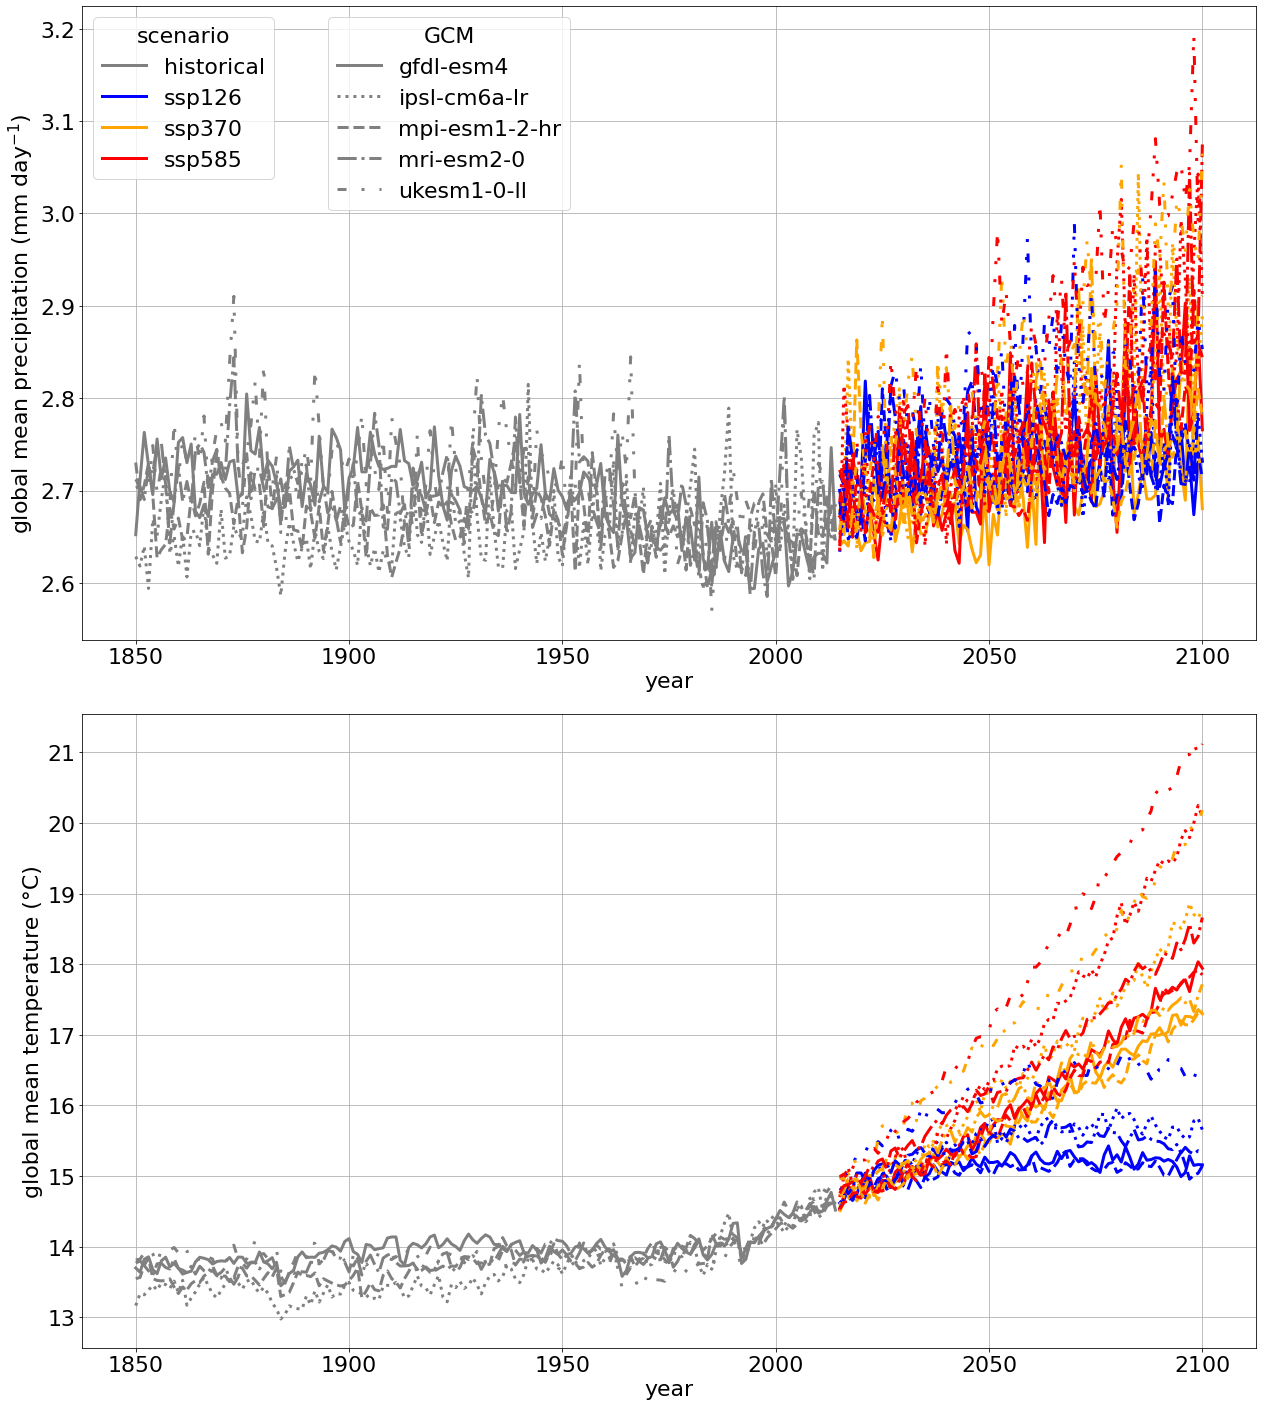

In [10]:
plt.rcParams.update({'font.size': 22})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,20))

lss = ['-',':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
for gcm, ls in zip(gcms,lss): 
    # visual test:
    for scenario, c in zip(scenarios, ['grey', 'blue', 'orange', 'red']):
        if scenario == 'historical':
            yr = np.arange(1850, 2015)
        else:
            yr = np.arange(2015, 2101)
        # ax1 = plt.subplot(2,1,1)
        ax1.plot(yr, dict_global_pr_mean['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax1.set_ylabel(r'global mean precipitation (mm day$^{-1}$)')
        ax1.set_xlabel('year')
        if ls == '-':
            legend1 = ax1.legend(loc=2, title = 'scenario')
        # ax2.subplot(2,1,2)
        ax2.plot(yr, dict_global_tas_mean['{}_{}'.format(gcm, scenario)],
                 label = '{}_{}'.format(gcm, scenario), color = c, ls = ls, lw=3)
        ax2.set_ylabel('global mean temperature (°C)')
        ax2.set_xlabel('year')
lines = ax1.get_lines()
legend2 = ax1.legend(lines[::4], gcms , loc=2, bbox_to_anchor=(0.2,1), title='GCM')
ax1.add_artist(legend1)
plt.tight_layout()
ax1.grid()
ax2.grid()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_global_mean_time_series_pr_temp.pdf');

### check the global mean daily temperature standard deviation

In [3]:
dict_global_tas_std_mean= {}
dict_global_tas_std_mean_1= {}
dict_global_tas_std_mean_7= {}
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']


for gcm in gcms:
    if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
        ensemble = 'r1i1p1f1'
    elif gcm == 'ukesm1-0-ll':
        ensemble = 'r1i1p1f2'
    for scenario in scenarios:
        print(gcm, ensemble, scenario)

        if scenario == 'historical':
            ybegin = 1850
            yend = 2014
        else:
            ybegin = 2015
            yend = 2100    

        typ = 'tasAdjust'
        folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
        path_output_tas_std = 'isimip3b/{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)
        
        ds_tas_daily_std = xr.open_dataset(path_output_tas_std)


    
        weight = np.cos(np.deg2rad(ds_tas_daily_std.lat))
        weight = weight / weight.sum()
        global_tas_daily_std_mean = (ds_tas_daily_std.tasAdjust_std.mean(dim='lon') * weight).sum(dim='lat').resample(time='1Y').mean() #- 273.15  # from K to °C
        global_tas_daily_std_mean_1 = (ds_tas_daily_std.tasAdjust_std.mean(dim='lon') * weight).sum(dim='lat').sel(time = ds_tas_daily_std['time.month'] == 1)
        global_tas_daily_std_mean_7 = (ds_tas_daily_std.tasAdjust_std.mean(dim='lon') * weight).sum(dim='lat').sel(time = ds_tas_daily_std['time.month'] == 7)
        #print('global precipitation mean: {} mm/day \nglobal temperature mean: {} °C'.format(global_pr_mean.mean().values.round(2), global_tas_mean.mean().values.round(2)))
        # check if they are approximately equal to literature values

        dict_global_tas_std_mean['{}_{}'.format(gcm, scenario)] = global_tas_daily_std_mean
        dict_global_tas_std_mean_1['{}_{}'.format(gcm, scenario)] = global_tas_daily_std_mean_1
        dict_global_tas_std_mean_7['{}_{}'.format(gcm, scenario)] = global_tas_daily_std_mean_7





gfdl-esm4 r1i1p1f1 historical
gfdl-esm4 r1i1p1f1 ssp126
gfdl-esm4 r1i1p1f1 ssp370
gfdl-esm4 r1i1p1f1 ssp585
ipsl-cm6a-lr r1i1p1f1 historical
ipsl-cm6a-lr r1i1p1f1 ssp126
ipsl-cm6a-lr r1i1p1f1 ssp370
ipsl-cm6a-lr r1i1p1f1 ssp585
mpi-esm1-2-hr r1i1p1f1 historical
mpi-esm1-2-hr r1i1p1f1 ssp126
mpi-esm1-2-hr r1i1p1f1 ssp370
mpi-esm1-2-hr r1i1p1f1 ssp585
mri-esm2-0 r1i1p1f1 historical
mri-esm2-0 r1i1p1f1 ssp126
mri-esm2-0 r1i1p1f1 ssp370
mri-esm2-0 r1i1p1f1 ssp585
ukesm1-0-ll r1i1p1f2 historical
ukesm1-0-ll r1i1p1f2 ssp126
ukesm1-0-ll r1i1p1f2 ssp370
ukesm1-0-ll r1i1p1f2 ssp585


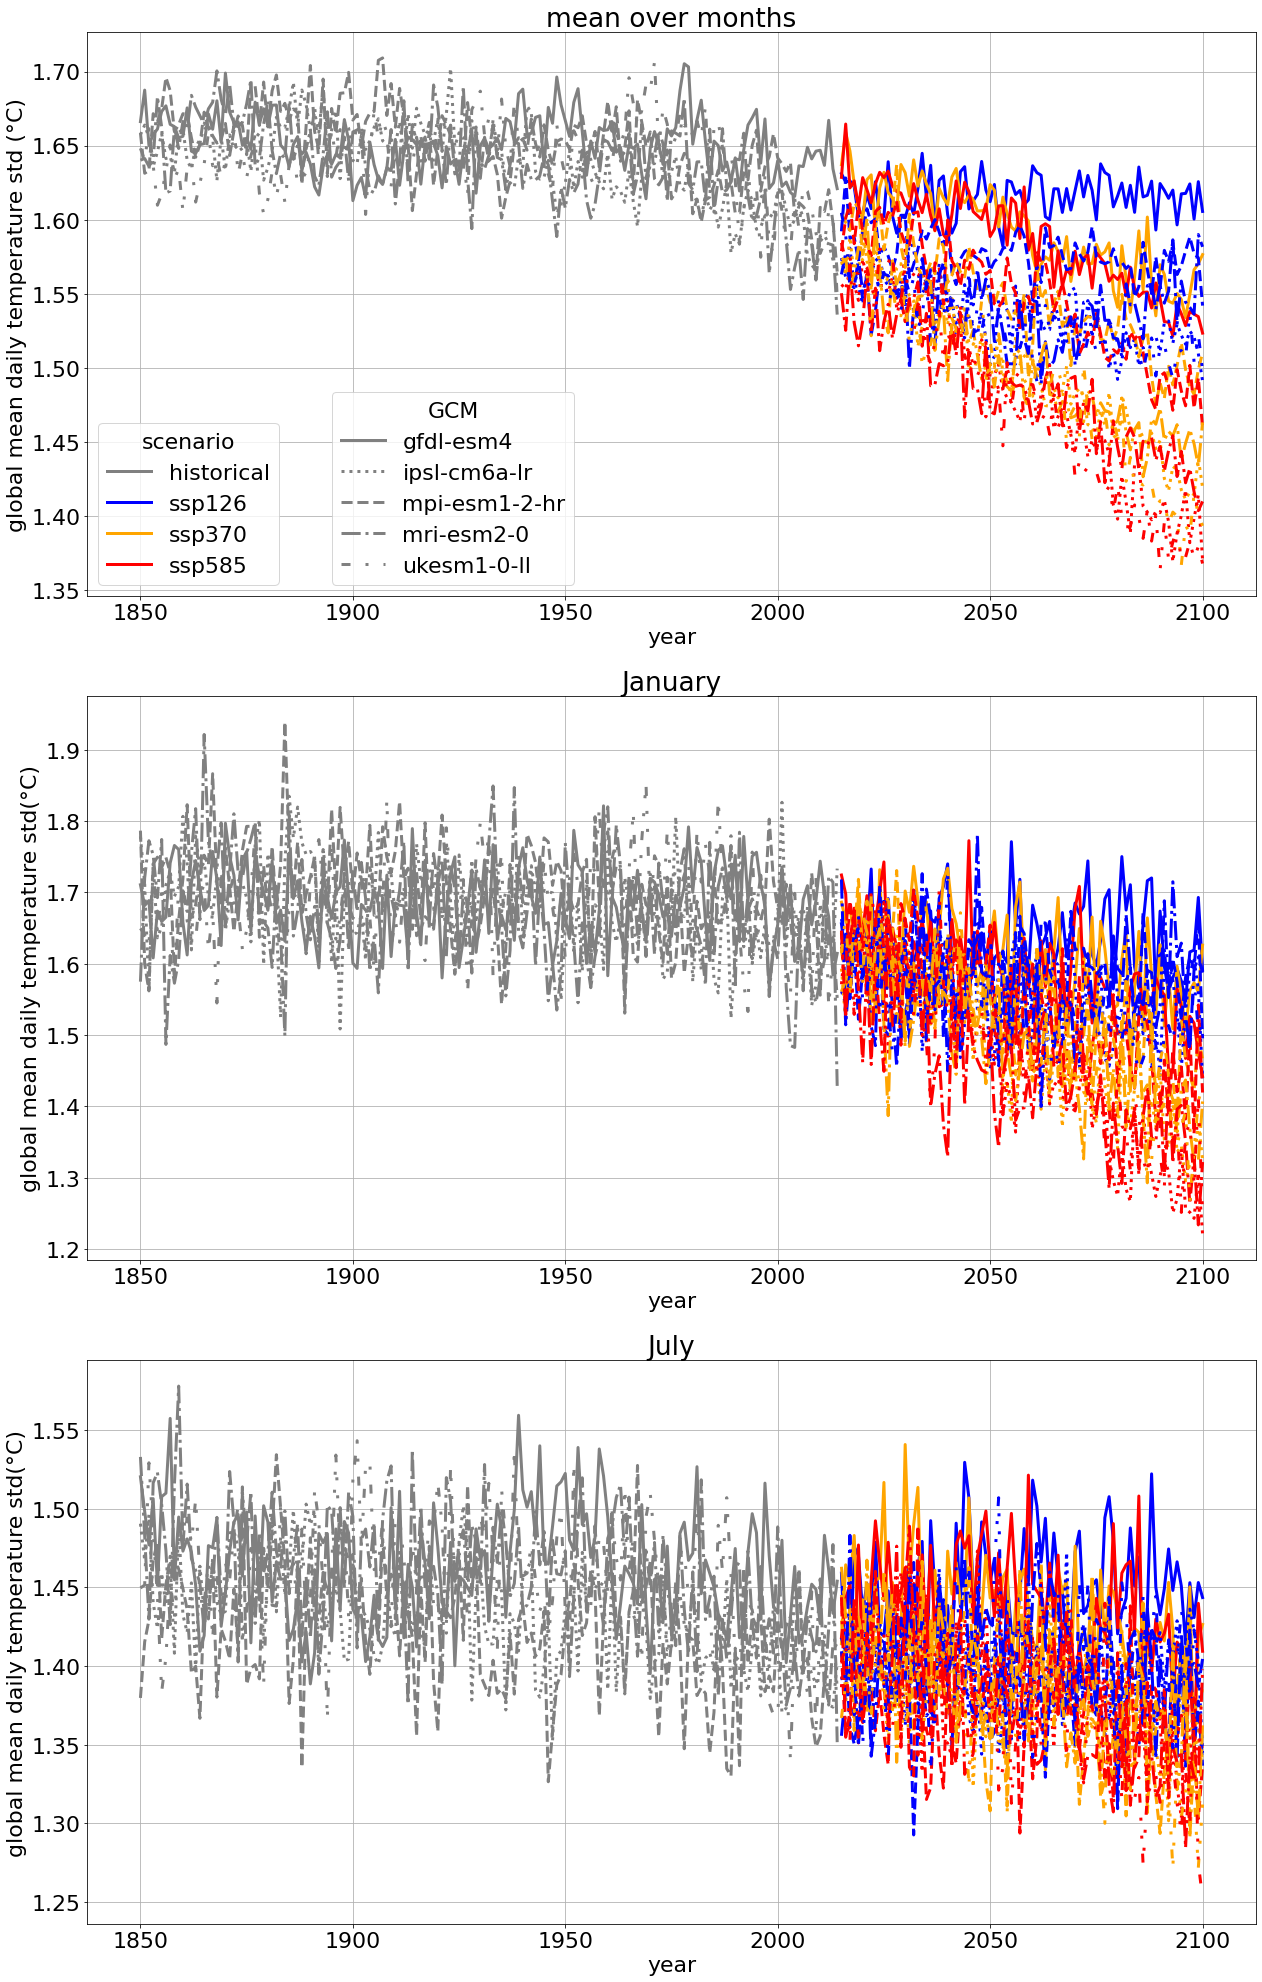

In [9]:
plt.rcParams.update({'font.size': 22})
#
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,28))
#fig, (ax1) = plt.subplots(1, 1, figsize=(18,10))

lss = ['-',':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
for gcm, ls in zip(gcms,lss): 
    # visual test:
    for scenario, c in zip(scenarios, ['grey', 'blue', 'orange', 'red']):
        if scenario == 'historical':
            yr = np.arange(1850, 2015)
        else:
            yr = np.arange(2015, 2101)
        #ax1 = plt.subplot(3,1,1)
        ax1.plot(yr, dict_global_tas_std_mean['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax1.set_ylabel(r'global mean daily temperature std (°C)')
        ax1.set_xlabel('year')
        ax1.set_title('mean over months')
        if ls == '-':
            legend1 = ax1.legend(loc=3, title = 'scenario')
        #ax2 = plt.subplot(3,1,2)
        ax2.plot(yr, dict_global_tas_std_mean_1['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax2.set_ylabel(r'global mean daily temperature std(°C)')
        ax2.set_title('January')
        ax2.set_xlabel('year')
        #####
        #ax3 = plt.subplot(3,1,3)
        ax3.plot(yr, dict_global_tas_std_mean_7['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax3.set_ylabel(r'global mean daily temperature std(°C)')
        ax3.set_title('July')
        ax3.set_xlabel('year')
        #ax2.plot(yr, dict_global_tas_mean['{}_{}'.format(gcm, scenario)],
        #        label = '{}_{}'.format(gcm, scenario), color = c, ls = ls, lw=3)
        #ax2.set_ylabel('global mean temperature (°C)')
        #ax2.set_xlabel('year')
lines = ax1.get_lines()
legend2 = ax1.legend(lines[::4], gcms , loc=3, bbox_to_anchor=(0.2,0), title='GCM')
ax1.add_artist(legend1)
plt.tight_layout()
ax1.grid()
ax2.grid()
ax3.grid()


plt.savefig('plots_isimip3b_analysis/plot_isimip3b_global_mean_time_series_temp_std.pdf');

- we can see that the temperature variance decrease is mostly in the Northern Hemisphere winter (at least when averaged over the globe), but to do this better we should instead look separately at Northern and Southern Hemisphere!

#### **some literature research on daily temperature standard deviation decreases in the future**:
it seems to be well known that temperature variance decreases in a warmer climate, at least in winter for the Northern Hemisphere:

- **Changes in Northern Hemisphere temperature variability shaped by regional warming patterns**, https://www.nature.com/articles/s41561-020-0576-3.pdf (Tamarin-Brodsky  et al., 2020)
    - see Fig. 1d, 
    - "To first order, the general  decrease  of  the  temperature  gradients  in  winter  leads  to  a  decrease  in  the  temperature  variance,  because,  by  advection  argu-ments,
      a  weaker  gradient  implies  weaker  anomalies "
- **Reduction in Northern Midlatitude 2-m Temperature Variability due to Arctic Sea Ice Loss**: https://doi.org/10.1175/JCLI-D-18-0692.1, (Collow et al., 2019)
    - "It is proposed that the weakened latitudinal temperature gradient, resulting from decreased sea ice, leads to reduced meridional temperature advection variability, which in turn contributes to the reduction in the variability of temperature anomalies. "
- **Arctic amplification decreases temperature variance in northern mid- to high-latitudes**: https://www.nature.com/articles/nclimate2268, (Screen et al., 2014)
    - Consistent with strong Arctic amplification, large decreases in temperature variance are projected in winter (Fig. 4d), and extend further south into mid-latitudes (to 40° N) than they do in autumn. 
    - " In spite of mean climate warming, an ostensibly large number of high-impact cold extremes have occurred in the Northern Hemisphere mid-latitudes over the past decade. One explanation is that Arctic amplification—the greater warming of the Arctic compared with lower latitudes12 associated with diminishing sea ice and snow cover—is altering the polar jet stream and increasing temperature variability. This study shows, however, that subseasonal cold-season temperature variability has significantly decreased over the mid- to high-latitude Northern Hemisphere in recent decades. This is partly because northerly winds and associated cold days are warming more rapidly than southerly winds and warm days, and so Arctic amplification acts to reduce subseasonal temperature variance. "(Screen et al., 2014)

### check if the files are equal to those from Harry Zekollari

In [9]:
gcm = 'ipsl-cm6a-lr'
ensemble = 'r1i1p1f1'
scenario = 'historical'
ybegin = 1850
yend = 2014

typ = 'prAdjust'
folder_output = 'isimip3b_{}_monthly'.format(typ)
path_output_pr = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
typ = 'tasAdjust'
folder_output = 'isimip3b_{}_monthly'.format(typ)
path_output_tas = 'isimip3b/{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
path_output_tas_std = 'isimip3b/{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)


my_pr_monthly = xr.open_dataset(path_output_pr)
my_tas_monthly = xr.open_dataset(path_output_tas)

In [10]:
test_pr = xr.open_dataset('isimip_test_zekollari/ipsl-cm6a-lr_r1i1p1f1_w5e5_historical_prAdjust_global_monthly_1850_2014.nc')
test_tas = xr.open_dataset('isimip_test_zekollari/ipsl-cm6a-lr_r1i1p1f1_w5e5_historical_tasAdjust_global_monthly_1850_2014.nc')

In [11]:
my_pr_monthly

<xarray.Dataset>
Dimensions:   (lat: 360, lon: 720, time: 1980)
Coordinates:
  * time      (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
  * lon       (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat       (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Data variables:
    prAdjust  (time, lat, lon) float32 ...
Attributes:
    title:                     ISIMIP3b bias-adjusted climate input data
    institution:               Potsdam Institute for Climate Impact Research ...
    contact:                   ISIMIP cross-sectoral science team <info@isimi...
    summary:                   CMIP6 daily output data bias-adjusted and stat...
    version:                   This file was published on 19 June 2020, see <...
    project:                   isimip3b
    product:                   input
    dataset_type:              Climate atmosphere simulated
    bias_correction:           W5E5-ISIMIP3BASD2
    world_region:              Global
    country:                   ALL
    time_frequency:            day
    model:                     IPSL-CM6A-LR
    experiment:                historical
    ensemble:                  r1i1p1f1
    publisher:                 ISIMIP coordination team <info@isimip.org>
    description:               IPSL-CM6A-LR bias corrected impact model input...
    doi:                       NA
    licence:                   CC BY 4.0
    creator:                   ISIMIP Coordination Team <info@isimip.org>
    tracking_id:               a4f335a4-403f-44d2-be45-d1f3eff0f563
    creation_date:             2020-06-20T01:53:26Z
    postprocessing_date:       2021-02-25
    postprocessing_scientist:  lilian.schuster@student.uibk.ac.at
    postprocessing_actions:    using xarray: ds = xr.open_mfdataset(isimip3b/...

In [12]:
test_pr

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 360, lon: 720, time: 1980)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    prAdjust   (time, lat, lon) float32 ...
Attributes:
    CDI:              Climate Data Interface version 1.9.2 (http://mpimet.mpg...
    history:          Tue Feb 23 15:59:26 2021: cdo mergetime prec1.nc prec10...
    institution:      Potsdam Institute for Climate Impact Research (PIK)
    Conventions:      CF-1.6
    title:            ISIMIP3b bias-adjusted climate input data
    contact:          ISIMIP cross-sectoral science team <info@isimip.org> <h...
    summary:          CMIP6 daily output data bias-adjusted and statistically...
    version:          This file was published on 19 June 2020, see <https://w...
    project:          isimip3b
    product:          input
    dataset_type:     Climate atmosphere simulated
    bias_correction:  W5E5-ISIMIP3BASD2
    world_region:     Global
    country:          ALL
    time_frequency:   day
    model:            IPSL-CM6A-LR
    experiment:       historical
    ensemble:         r1i1p1f1
    publisher:        ISIMIP coordination team <info@isimip.org>
    description:      IPSL-CM6A-LR bias corrected impact model input prepared...
    doi:              NA
    licence:          CC BY 4.0
    creator:          ISIMIP Coordination Team <info@isimip.org>
    tracking_id:      a4f335a4-403f-44d2-be45-d1f3eff0f563
    creation_date:    2020-06-20T01:53:26Z
    frequency:        mon
    CDO:              Climate Data Operators version 1.9.2 (http://mpimet.mpg...

they have the same shape, except that "my" files don't have a time_bnds but I don't think that this is necessary 

the values are also the same:

In [13]:
np.testing.assert_allclose(my_pr_monthly.prAdjust.values, test_pr.prAdjust.values, rtol = 1e-6)

In [14]:
np.testing.assert_allclose(my_tas_monthly.tasAdjust.values, test_tas.tasAdjust.values, rtol = 1e-6)